# Text analysis workbook



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MNoichl/data-driven-philosophy-GAP2025/blob/main/workbook_01_text_analysis.ipynb) 

Welcome to google colab! Colab is a cloud-based notebook environment that allows you to write and execute code in the python programming language in the browser. It follows a notebook structure (like jupyter) in which you can write markdown text like this, as well as code in cells that can be executed.

Below is one of these cells. You can run it either by clicking the little (▶️) button on the top left of the cell, or by clicking into it and then pressing shift+enter:


In [3]:
print("Hello World")


Hello World


If you want to continue working on this notebook, and make your own changes to the code, we'd reccomend you save your own copy, by clicking the "File" menu at the top left, and then "Save a copy in Drive". Please do this as it's easy to loose your work otherwise. You can then edit your own copy. You can also download it as an .ipynb file by clicking the "File" menu at the top left, "Download", and then "Download .ipynb". If you want to learn more about the functionalites of colab notebooks, we reccommend looking at this [basic colab features-notebook.](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

** Important:** Below we are going to run a LLM. This needs a more powerful computer, called an LLM. You can select this by doing Runtime -> Change Runtime Type -> T4 GPU.

# Part 1: Set-up
At the beginning of this notebook, we need to set up all of the libraries/packages (reusable python-programs other people have written) that we are going to use during this session. For this we use a common python-package manager called 'pip'. Pip takes care of downloading the right versions, and installing them on our computer, which in this case is a server that's standing in a google-data-center, maybe in Belgium or Iowa. These installs will take a minute or two.

In [4]:
%%capture

!pip install pandas
!pip install pyalex
!pip install umap-learn
!pip install datamapplot
!pip install upgrade sentence-transformers 
!pip install seaborn
!pip install genieclust
!pip install litellm
!pip install opinionated
!pip install keybert
!pip install keyphrase-vectorizers
!pip install -q --upgrade "transformers>=4.45.2" "sentence-transformers>=3.0.1"
!pip install --upgrade 'nltk==3.8.1' 

#%pip install -q --upgrade "transformers==4.44.2" "sentence-transformers==2.7.0" "accelerate>=0.33" "keybert>=0.8.5" "torch>=2.2,<2.5"



# Check if utils directory exists, if not download from GitHub
import os
if not os.path.exists('utils'):
    !wget -q https://raw.githubusercontent.com/MNoichl/data-driven-philosophy-GAP2025/main/utils/openalex_utils.py -P utils/
    # Create __init__.py to make it a proper Python package
  #  !touch utils/__init__.py



# Part 2: Imports

After setting up the packages, we need to import them. This makes the code in the packages available for us to use later. 

In [41]:
# Enable autoreload for development
%load_ext autoreload
%autoreload 2

# Core data science libraries
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical computing and arrays
import os           # Operating system interface

# Visualization libraries
import matplotlib.pyplot as plt  # Basic plotting functionality
import seaborn as sns           # Statistical data visualization
from matplotlib.colors import rgb2hex

# Academic data access
import pyalex  # Interface to OpenAlex academic database

# Dimensionality reduction and clustering
import umap         # Uniform Manifold Approximation and Projection
import datamapplot  # Interactive visualization for high-dimensional data

# Natural language processing and AI
import sentence_transformers  # Sentence embeddings using transformer models
import litellm                # Unified interface for various LLM APIs

# Styling and aesthetics
import opinionated  # Opinionated matplotlib styling
plt.style.use('opinionated_rc')
import colormaps as colormaps  # Extended colormap collection - https://pratiman-91.github.io/colormaps/



from utils.openalex_utils import openalex_url_to_pyalex_query, process_records_to_df, get_records_from_dois, openalex_url_to_filename, download_openalex_records

# Part 3: Getting data

In this notebook we are interested in analysing textual data. For this we have prepared a dataset of texts from the *Stanford Encyclopedia of Philosophy*. Alternatively, we have set up code that allows you to quickly scrape your own dataset of abstracts from the *OpenAlex*-database. Finally, if you have your owns data-source to work with, we can show you how to hook it up to this notebook below. **Important:** You will only want to run one of the three sub-sections below. 

# Part 3.1 Stanford-Encyclopedia dataset

The code below downloads a zip-file of SEP-articles, and loads the texts into memory as a list, text_data.

In [10]:
import requests
import zipfile
from pathlib import Path

# Download and extract if needed
stanford_zip = Path("stanford-encyclopedia.zip")
stanford_folder = Path("stanford-encyclopedia")
if not stanford_zip.exists():
    zip_data = requests.get("https://github.com/MNoichl/data-driven-philosophy-GAP2025/raw/refs/heads/main/files/stanford-encyclopedia.zip").content
    with zipfile.ZipFile(zipfile.io.BytesIO(zip_data)) as zip_ref:
        zip_ref.extractall(".")

# Load data
text_data = [open(f, encoding='utf-8').read() for f in stanford_folder.glob("*.md")]
title_data = [f.stem for f in stanford_folder.glob("*.md")]
# Extract year data from copyright strings in the text files
import re

year_data = []
for text in text_data:
    # Look for "Copyright © YYYY" pattern at the beginning of the text
    match = re.search(r'Copyright © (\d{4})', text)  
    if match:
        year_data.append(int(match.group(1)))
    else:
        year_data.append(None)  # If no copyright year found

used_dataset = "Stanford Encyclopedia"

## Part 3.2 OpenAlex-datasets.

We have written a function that takes in an arbitrary url to a OpenAlex search query, and downloads the abstracts associated with it. To use it, head over to [https://openalex.org](https://openalex.org), search for something you are interested in, and copy the web-address of your search address. Then replace the url behind ` openalex_url = `  with the new one. Make sure to keep the quotation marks around it. That tells python that this is a string of text, and not executable python code. 

In [ ]:
openalex_url = 'https://openalex.org/works?page=1&filter=primary_location.source.id:s255146,publication_year:2005-2025'

dataset_df = download_openalex_records(openalex_url,
                                       reduce_sample=True, 
                                       sample_reduction_method="n random samples", 
                                       sample_size=1000, 
                                       seed_value="42")


dataset_df['text'] = dataset_df['title'] + dataset_df['abstract'] 
# We filter for works that have an abstract:
dataset_df = dataset_df[dataset_df['text'].str.len() > 10]

text_data = list(dataset_df['text'])
year_data = dataset_df['publication_year']
title_data = dataset_df['title']

used_dataset = "OpenAlex-query"






Input: https://openalex.org/works?page=1&filter=primary_location.source.id:s255146,publication_year:2005-2025
Starting data projection pipeline
Filename: primary_location_source_id_s255146__publication_year_2005-2025__20250905_200746
Requesting 6756 entries from query 1/1 (expecting to download 5000)...
Attempting PyAlex sampling: 5000 from 6756 (seed=42)
PyAlex sampling successful: got 5000 records (requested 5000)
Query completed in 44.40 seconds
Total records collected: 5000
Expected to download: 5000
Available from all queries: 6756
Sample method used: n random samples
Reduce sample enabled: True
Seed value: 42


# 3.3 Bring your own data

Below you can hook up your own dataset. The remainder of the notebook expects `text_data`and  `title_data`to be lists of strings, and  `year_data`to be a list of numbers.


In [ ]:
text_data = "..."
title_data = "..."
year_data = "..."

used_dataset = "NAME YOUR DATASET HERE"

# Named Entity Recognition (NER)

# Part 4: Using a language model 
We are now going to use a text-embedding model (a relatively small large language model) to transform the texts into a format which is easier to analyze mathematically.  The most famous of these models is called BERT (Bidirectional encoder representations from transformers), but there are many models you can choose from for this purpose. Look around e. g. here: [https://www.sbert.net/docs/sentence_transformer/pretrained_models.html ](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html )

While they are trained on different datasets and can have a variety of different architectures, their main principles are very similar: Sub-word-particles, called tokens, are associated with long strings of numbers, called embeddings. These embeddings learned during the training-process. When presented with new texts, as we are going to do below, the model cuts the text up into the tokens, and selects the associated embeddings. The embeddings then undergo a process called 'attention' in which the individual representations interact with, and change each-other. In this process, the model adapts the individual embeddings to their context, and changes e.g. the embeddings associated with 'bank', depending on whether the word is close to 'river', as opposed to 'deposit'. Finally, the embeddings of all the tokens in the text get summarized, e.g. by averaging thm. This final embedding, whihc contains information from all the tokens then gets used to represent the whole text.



In [11]:
from sentence_transformers import SentenceTransformer

model_name = "all-mpnet-base-v2" # "answerdotai/ModernBERT-base",  "Qwen/Qwen3-Embedding-0.6B"
model = SentenceTransformer(model_name) #thenlper/gte-small
embeddings = model.encode([x[:3000] for x in text_data],
                          show_progress_bar=True)


Batches: 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


This is what the resulting embeddings look like - each row represents one of our texts:


In [12]:
print(embeddings)

[[-0.01874151  0.08301561  0.015416   ...  0.02144149  0.05794398
   0.0353681 ]
 [ 0.03687045  0.05698193 -0.01726884 ...  0.03108266 -0.04500982
  -0.01516257]
 [ 0.02601817  0.05356497  0.02862665 ...  0.02747844  0.01709747
   0.043333  ]
 ...
 [-0.01187475  0.03380273  0.01130016 ...  0.05354805  0.01731879
  -0.00169753]
 [ 0.04277813 -0.02048375 -0.02450627 ...  0.0064866   0.02048556
   0.00294893]
 [ 0.10349022  0.02489288  0.00177084 ...  0.02375395  0.03063722
  -0.00689657]]


# Part 5: doing dimensionality reduction


N

In [13]:
import umap


reducer = umap.UMAP(n_components=2, random_state=42,metric='cosine')
umap_embeddings = reducer.fit_transform(embeddings)

print(umap_embeddings)


/Users/Noich001/Desktop/workbooks_GAP_workshop/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[[10.9355755  4.740214 ]
 [11.846191   5.755088 ]
 [ 4.1749916  4.147809 ]
 ...
 [ 8.451248   6.936898 ]
 [12.872176   3.6239636]
 [ 3.7756402  8.916081 ]]


We can also look at the embeddings as a scatter-plot. Each data-point is one of our texts:

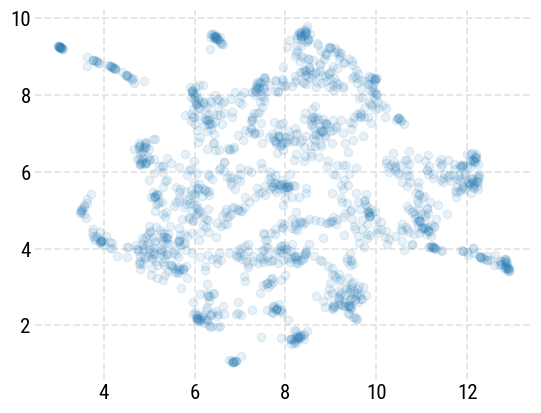

In [14]:
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],alpha=0.1)
plt.show()

# Part 5: Clustering 

In [15]:
import genieclust

reducer = umap.UMAP(n_components=30, random_state=42,metric='cosine')
umap_embeddings_high_dim = reducer.fit_transform(embeddings)

g = genieclust.Genie(n_clusters=15, gini_threshold=0.3)
cluster_labels = g.fit_predict(umap_embeddings_high_dim)
print(cluster_labels[0:20])

/Users/Noich001/Desktop/workbooks_GAP_workshop/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[0 1 2 3 4 0 1 5 6 5 2 5 5 3 0 0 0 4 7 5]


Create a dictionary of colors:

In [34]:
# Get unique cluster labels
unique_clusters = np.unique(cluster_labels)
n_clusters = len(unique_clusters)

# Get colors from antique colormap, repeating if necessary
antique_colors = colormaps.antique(np.linspace(0, 1, colormaps.antique.N))
repeated_colors = np.tile(antique_colors, (n_clusters // colormaps.antique.N + 1, 1))[:n_clusters]

custom_color_map = dict(
    zip(
        unique_clusters,
        map(rgb2hex, repeated_colors)
    )
)

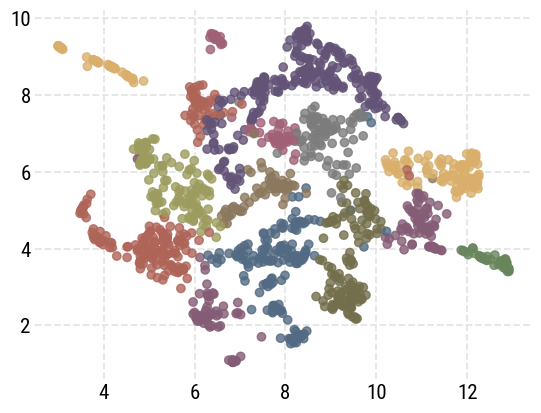

In [35]:
plt.scatter(x=umap_embeddings[:, 0], 
            y=umap_embeddings[:, 1],
            c=[custom_color_map[x] for x in cluster_labels],
            alpha=0.8)

# Part 6: Labeling clusters

In [17]:
API_KEY = "..."


if API_KEY == "...": # This code below is only for local development. You can ignore it!
    with open('API_KEYS.txt', 'r') as file:
        for line in file:
            if line.startswith('OPENAI:'):
                API_KEY = line.split(':', 1)[1].strip()
                break
        else:
            raise ValueError("OPENAI API key not found in API_KEYS.txt")

os.environ["OPENAI_API_KEY"] = API_KEY

Below we create our labels... Feel free to play with the prompt.

In [18]:
from litellm import completion
import pandas as pd
import random
import json

# Create a function to label clusters using OpenAI
def label_cluster(cluster_texts, cluster_id, n_samples=10):
    # Randomly sample representative texts from the cluster (max 10 for efficiency)
    sample_size = min(10, len(cluster_texts))
    sample_texts = random.sample(cluster_texts, sample_size)
    
    # Truncate texts to 100 characters
    sample_texts = [text[:1000] + "..." if len(text) > 1000 else text for text in sample_texts]
    
    prompt = f"""
    Below are randomly sampled texts from cluster {cluster_id}. Please analyze these texts and provide:
    1. A short descriptive label (2-4 words) for the area of philosophy that the texts are from. Try to pick labels that are commonly used.
    2. A brief description of the main theme

    Texts:
    {chr(10).join([f"- {text[:200]}..." if len(text) > 200 else f"- {text}" for text in sample_texts])}
    
    Please respond in JSON format:
    {{
        "label": "[your label]",
        "description": "[your description]"
    }}
    """
    
    messages = [{"content": prompt, "role": "user"}]
    response = completion(model="openai/gpt-5", messages=messages, response_format={"type": "json_object"})
    return response.choices[0].message.content

# Group texts by cluster
cluster_groups = {}
for i, label in enumerate(cluster_labels):
    if label not in cluster_groups:
        cluster_groups[label] = []
    cluster_groups[label].append(text_data[i])

# Label each cluster
cluster_info = {}
for cluster_id, texts in cluster_groups.items():
    print(f"Labeling cluster {cluster_id} ({len(texts)} texts)...")
    label_info = label_cluster(texts, cluster_id, n_samples=5)
    cluster_info[cluster_id] = label_info
    print(f"Cluster {cluster_id}: {label_info}\n")

# Create a summary dataframe
cluster_summary = []
for cluster_id, info in cluster_info.items():
    # Parse the JSON response
    try:
        parsed_info = json.loads(info)
        label = parsed_info.get('label', 'Unknown')
        description = parsed_info.get('description', 'No description available')
    except (json.JSONDecodeError, TypeError):
        # Fallback if JSON parsing fails
        label = f"Cluster {cluster_id}"
        description = str(info)
    
    cluster_summary.append({
        'Cluster_ID': cluster_id,
        'Size': len(cluster_groups[cluster_id]),
        'Label': label,
        'Description': description
    })

cluster_df = pd.DataFrame(cluster_summary)
cluster_df

Labeling cluster 0 (76 texts)...
Cluster 0: {
  "label": "Late Scholasticism and Humanism",
  "description": "Profiles of 13th–17th century European thinkers whose work in logic, metaphysics, theology, and rhetoric marks the transition from medieval scholastic thought to Renaissance humanism and early modern reforms in church, education, and public discourse."
}

Labeling cluster 1 (108 texts)...
Cluster 1: {
  "label": "Ancient Philosophy",
  "description": "Works centered on Plato, Aristotle, and their late antique legacy, covering metaphysics (causality, categories), logic, ethics, rhetoric, skepticism, and Neoplatonism, including their transmission into late antiquity and medieval thought."
}

Labeling cluster 2 (146 texts)...
Cluster 2: {
  "label": "Normative Political Philosophy",
  "description": "Evaluates the moral foundations of political authority and institutions, focusing on justice, rights, and distribution at domestic and global scales. Debates democracy, anarchism, con

,Cluster_ID,Size,Label,Description
0,0,76,Late Scholasticism and Humanism,Profiles of 13th–17th century European thinker...
1,1,108,Ancient Philosophy,"Works centered on Plato, Aristotle, and their ..."
2,2,146,Normative Political Philosophy,Evaluates the moral foundations of political a...
3,3,74,German Continental Philosophy,Development of German-rooted Continental thoug...
4,4,164,Modern and Contemporary Philosophy,Profiles of key figures and movements from the...
5,5,250,Formal Logic and Foundations,Works centered on formal approaches to reasoni...
6,6,46,Medieval Islamic Philosophy,Core figures and schools in the Islamic world ...
7,7,124,Biology and Rational Choice,"Explores teleology, levels of organization, in..."
8,8,65,Philosophy of Science,Examines the foundations and methods of scient...
9,9,64,Philosophy of Religion,Philosophical analysis of religion and theism:...


In [37]:
# Create a labels list from cluster_labels and the labeled cluster descriptions
labels_list = []
for cluster_id in cluster_labels:
    # Find the corresponding label from the cluster_df
    cluster_row = cluster_df[cluster_df['Cluster_ID'] == cluster_id]
    if not cluster_row.empty:
        label = cluster_row.iloc[0]['Label']
    else:
        label = f"Cluster {cluster_id}"
    labels_list.append(label)

# Update the custom_color_map to use cluster labels instead of cluster IDs
custom_color_map = {}
for cluster_id in unique_clusters:
    # Find the corresponding label from the cluster_df
    cluster_row = cluster_df[cluster_df['Cluster_ID'] == cluster_id]
    if not cluster_row.empty:
        label = cluster_row.iloc[0]['Label']
    else:
        label = f"Cluster {cluster_id}"
    
    # Get the color for this cluster_id from the original mapping
    color_index = list(unique_clusters).index(cluster_id)
    color = rgb2hex(repeated_colors[color_index])
    custom_color_map[label] = color




# Part 7: Visualizing

## 7.1 An interactive data-map

<InteractiveFigure width=100% height=800>
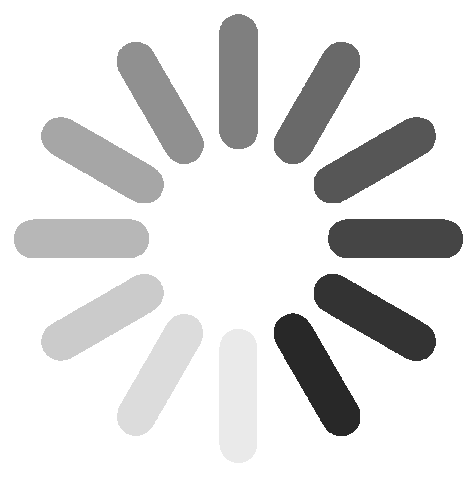

In [38]:
import datamapplot

datamapplot.create_interactive_plot(
    umap_embeddings,
    labels_list,  # label layer
    hover_text=title_data,  # hover_text must be the 2nd positional
    label_color_map=custom_color_map,
    title=used_dataset
)

## 7.2 Historical developments

In [26]:
# Prepare data for streamgraph visualization
# Convert the year_data and clusters into the format expected by plot_streamgraph

# Get unique years and sort them
years_sorted = sorted(set(year_data))
X_stream = np.array(years_sorted)

# Get unique clusters and their labels
unique_clusters = sorted(set(cluster_labels))
cluster_labels_to_plot = []
for cluster_id in unique_clusters:
    if cluster_id in cluster_df['Cluster_ID'].values:
        label = cluster_df[cluster_df['Cluster_ID'] == cluster_id]['Label'].iloc[0]
        cluster_labels_to_plot.append(label)
    else:
        cluster_labels_to_plot.append(f"Cluster {cluster_id}")

# Create Y matrix: each row is a cluster's values over time
Y_stream = []
for cluster_id in unique_clusters:
    cluster_values = []
    for year in years_sorted:
        # Count documents in this cluster for this year
        cluster_count = sum(1 for i, (doc_year, doc_cluster) in enumerate(zip(year_data, cluster_labels)) 
                           if doc_year == year and doc_cluster == cluster_id)
        cluster_values.append(cluster_count)
    Y_stream.append(cluster_values)

Y_stream = np.array(Y_stream)

print(f"Streamgraph data prepared:")
print(f"X (years): {len(X_stream)} points from {X_stream[0]} to {X_stream[-1]}")
print(f"Y (clusters): {Y_stream.shape[0]} clusters × {Y_stream.shape[1]} time points")
print(f"Cluster labels: {cluster_labels_to_plot[:3]}...")  # Show first 3 labels


Streamgraph data prepared:
X (years): 16 points from 2003 to 2018
Y (clusters): 15 clusters × 16 time points
Cluster labels: ['Late Scholasticism and Humanism', 'Ancient Philosophy', 'Normative Political Philosophy']...


<Axes: >

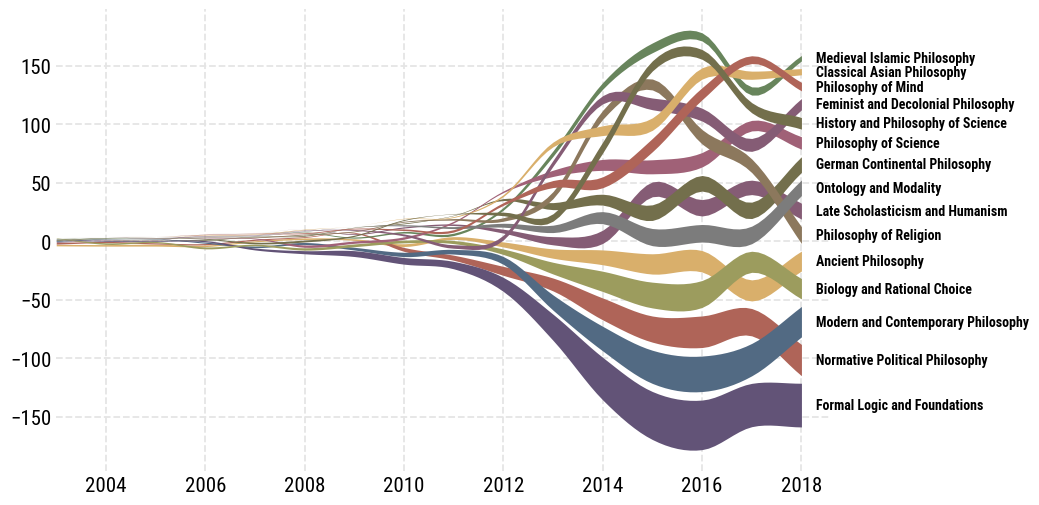

In [44]:
from utils.streamgraph import plot_streamgraph
import numpy as np




# 2) curved edges only, values unchanged
plot_streamgraph(X_stream, Y_stream, labels=cluster_labels_to_plot,
                    sorted_streams=True,
                    margin_frac=0.4,
                    smooth_window=3,
                    cmap=custom_color_map,
                    curve_samples=7, label_position='end',label_color='black',
)